In [1]:
# Sbi
import sbi
from sbi.utils.get_nn_models import likelihood_nn
from sbi.analysis import pairplot
from sbi import inference

# Sbi benchmark
import sbibm
from sbibm.metrics import c2st, mmd

# torch and so
import torch
from torch import nn
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt

D:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# Loads a model...
task = sbibm.get_task("gaussian_linear") 


# SNLVI - Simulation based inference

One crucial point for simulation based inference is ** simulation efficiency **. This is because typically the simulator is expensive to run, hence we want to decrease the number of necessary simulations. To increase simulation efficiency notice that we actually only have to learn the likelihood at regions where the posterior density is large! Thus optimally we draw samples form the posterior, simulate them, then learn the likelihood. This motivites a sequential training procedure:
* Start with some samples $\theta \sim p(\theta)$ and $x \sim s(\theta)$, where $s$ is the simulator and $p$ the prior.
* For 1...R rounds:
    * Learn the likelihood $p(x|\theta)$ with current amount of data.
    * Learn the posterior $q_\phi(\theta)$ with VI.
    * Sample $\theta \sim q_\phi(\theta)$ and simualte $x \sim s(\theta)$.
    * Append to new samples to dataset.

As we learn the likelihood we do not have to correct for using the $q$ not the prior. 

In [5]:
def train_multi_round_posterior(task, num_observation, num_round=10, num_samples=100, retrain_from_scratch=False):
    observation = task.get_observation(num_observation=num_observation) 
    prior = task.prior_dist
    simulator = task.get_simulator()

    # Starting dataset
    proposal = prior
    inf = inference.SNLVI(prior)
    posteriors = []
    simulations = [0]
    for r in range(num_round):
        theta = proposal.sample((num_samples,))
        x = simulator(theta)
        simulations.append(simulations[-1] + num_samples)
        density_estimator = inf.append_simulations(theta, x, from_round=r).train()
        if r == 0 or retrain_from_scratch:
            posterior = inf.build_posterior(density_estimator, flow="spline_autoregressive", num_flows=5)
        else:
            posterior.net = density_estimator
        posterior.set_default_x(observation)
        posterior.train(show_progress_bar=True)
        posteriors.append(deepcopy(posterior))
        proposal = posterior
    return posteriors, simulations

In [6]:
def evaluate_c2st(task, num_observation, posteriors):
    target_samples = task.get_reference_posterior_samples(num_observation)
    acc = []
    for post in posteriors:
        samples = post.sample((10000,))
        c2t = c2st(target_samples, samples)
        acc.append(c2t)
    return c2t

In [7]:
def evaluate_mmd(task, num_observation, posteriors):
    target_samples = task.get_reference_posterior_samples(num_observation)
    metrics = []
    for post in posteriors:
        samples = post.sample((10000,))
        met = mmd(target_samples, samples)
        metrics.append(met)
    return metrics

In [17]:
posterior_single = train_multi_round_posterior(task, 1, num_round=1, num_samples=1000)

Neural network successfully converged after 143 epochs.
Loss: 2.65:   7%|▋         | 138/2000 [00:08<01:55, 16.09it/s]

In [ ]:
posterior_single[0][0]

In [ ]:
from pyro.ops.stats import autocorrelation, autocovariance
from sbi.vi.paretto_smoothed_is import gpdfit, gpd_pdf
posterior_single[0][0].train(max_num_iters=2000, gamma=0.9)

In [24]:
self = posterior_single[0][0].optimizer

D:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


NameError: name 'task' is not defined

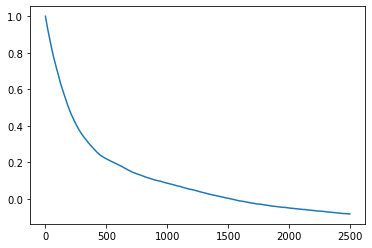

In [14]:
x = np.array(posterior_single[0][0].optimizer.summarize()[0])
autocorr = np.correlate(x-x.mean(),x-x.mean(), mode="same")
autocorr = autocorr[int(autocorr.size/2):]/autocorr[int(autocorr.size/2)]
plt.plot(autocorr)

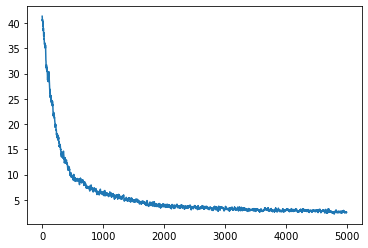

In [15]:
plt.plot(x)

In [47]:
metric_single = evaluate_mmd(task, 1, posterior_single[0])

In [14]:
metric_single

[tensor(0.0302)]

In [35]:
posteriors = train_multi_round_posterior(task, 1)

Neural network successfully converged after 190 epochs.
Neural network successfully converged after 26 epochs.
Neural network successfully converged after 21 epochs.
Neural network successfully converged after 28 epochs.
Neural network successfully converged after 21 epochs.
Neural network successfully converged after 37 epochs.
Neural network successfully converged after 22 epochs.
Neural network successfully converged after 24 epochs.
Neural network successfully converged after 28 epochs.
Neural network successfully converged after 22 epochs.


In [57]:
posteriors[0][-5].train(max_num_iters=100, learning_rate=1e-3, n_particles=1000)

Loss: 9.98: 100%|██████████| 100/100 [00:03<00:00, 29.20it/s]
Quality Score: 0.005 (smaller values are good, should be below 1, mode collapse may still occured.)


In [58]:
metric = evaluate_mmd(task, 1, posteriors[0])

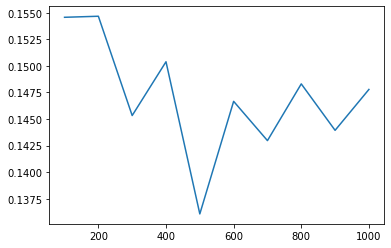

In [59]:
plt.plot(posteriors[1][1:],metric)

On advantage of variational inference over mcmc is that we can jountly optimize the posterior and likelihood distributions at the same time, instead of making this round wise we will simulate every time from the current posterior! However in the beginning we should not trust the posterior estimate, hence we sample the mixture $\alpha p(\theta) + (1-\alpha)q_\phi(\theta)$ where we let $\alpha \rightarrow 0$ with increasing amount of iterations.

In [76]:
def train_snlpvi(task, num_observation, simulations_per_round=5, max_num_simulations=1000, retrain_from_scratch=False):
    observation = task.get_observation(num_observation=num_observation) 
    prior = task.prior_dist
    simulator = task.get_simulator()

    # Starting dataset
    inf = inference.SNLVI(prior)
    
    alpha = 1.
    proposal = lambda: prior.sample((simulations_per_round,))
    posteriors = []
    simulations = [0]
    num_rounds = int(max_num_simulations/simulations_per_round)
    for r in range(num_rounds):
        theta = proposal()
        x = simulator(theta)
        simulations.append(simulations[-1] + simulations_per_round)
        density_estimator = inf.append_simulations(theta, x, from_round=r).train(max_num_epochs=50)
        if r == 0:
            posterior = inf.build_posterior(density_estimator, flow="affine_autoregressive", num_flows=2)
            posterior.set_default_x(observation)
            proposal = lambda : prior.sample((simulations_per_round,)) if torch.rand(1) < alpha else posterior.sample((simulations_per_round,))
        posterior.net = density_estimator
        posterior.train(show_progress_bar=False, min_num_iters=1,max_num_iters=50)
        posteriors.append(deepcopy(posterior))
        alpha /= 2
    return posteriors, simulations

In [77]:
posteriors_snlpvi = train_snlpvi(task, 1, max_num_simulations=1000)

Neural network successfully converged after 21 epochs.
Neural network successfully converged after 25 epochs.
Neural network successfully converged after 22 epochs.
Neural network successfully converged after 28 epochs.
Neural network successfully converged after 21 epochs.
Neural network successfully converged after 21 epochs.
Neural network successfully converged after 30 epochs.
Neural network successfully converged after 21 epochs.
Neural network successfully converged after 21 epochs.
Neural network successfully converged after 22 epochs.
Neural network successfully converged after 21 epochs.
Neural network successfully converged after 21 epochs.
Neural network successfully converged after 21 epochs.
Neural network successfully converged after 21 epochs.
Neural network successfully converged after 21 epochs.
Neural network successfully converged after 21 epochs.
Neural network successfully converged after 32 epochs.
Neural network successfully converged after 21 epochs.
Neural net

In [78]:
posts = []
num_sim = []
for i in range(len(posteriors_snlpvi[0])):
    if i % 10 == 0:
        posts.append(posteriors_snlpvi[0][i])
        num_sim.append(posteriors_snlpvi[1][i+1])

In [79]:
metric_snlpvi = evaluate_mmd(task, 1, posts)

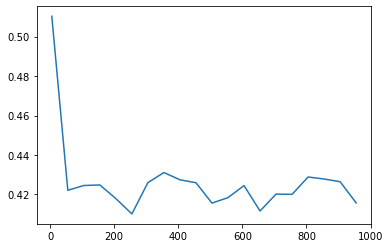

In [80]:
plt.plot(num_sim, metric_snlpvi)

Next notice that to efficently learn the likelihood we not only care about samples from the current posterior but samples that have high posterior probability but also has not been seen so far. Assume $\hat{p}(\theta)$ is a approximation of the densities of $\theta's$ seen so far.

The next simulation thus should be for a $\theta$ that maximizes $\log \frac{q_\phi(\theta)}{\hat{p}(\theta)}$.

In [8]:
 from scipy.stats import gaussian_kde

In [9]:
def train_snlpvi2(task, num_observation, simulations_per_round=5, max_num_simulations=1000, retrain_from_scratch=False):
    observation = task.get_observation(num_observation=num_observation) 
    prior = task.prior_dist
    simulator = task.get_simulator()

    # Starting dataset
    inf = inference.SNLVI(prior)
    
    proposal = prior
    posteriors = []
    simulations = [0]
    num_rounds = int(max_num_simulations/simulations_per_round)
    for r in range(num_rounds):
        
        if r > 5:
            theta = proposal.sample((500,))
            all_thetas, _, _ = inf.get_simulations()
            kde = gaussian_kde(all_thetas.T)
            log_q = posterior.q.log_prob(theta).detach().numpy()
            log_p = kde(theta.detach().numpy().T)
            sorted, indices = torch.sort(torch.tensor(log_q - log_p))
            theta = theta[indices[-5:]]
        else:
            theta = proposal.sample((5,))
        
        x = simulator(theta)
        simulations.append(simulations[-1] + simulations_per_round)
        density_estimator = inf.append_simulations(theta, x, from_round=r).train(max_num_epochs=10)
        if r == 0:
            posterior = inf.build_posterior(density_estimator, flow="affine_autoregressive", num_flows=2)
            posterior.set_default_x(observation)
        posterior.net = density_estimator
        posterior.train(show_progress_bar=False, min_num_iters=1,max_num_iters=20)
        posteriors.append(deepcopy(posterior))
        if r > 5:
            proposal = posterior.q

    return posteriors, simulations

In [10]:
posteriors_snlpvi2 = train_snlpvi2(task, 1, max_num_simulations=1000)
metric_snlpvi2 = evaluate_mmd(task, 1, posteriors_snlpvi2[0])

In [4]:
num_observation=1
observation = task.get_observation(num_observation=num_observation) 
prior = task.prior_dist
simulator = task.get_simulator()

# Starting dataset
inf = inference.SNLVI(prior)

proposal = prior
posteriors = []
simulations = [0]
num_rounds = int(max_num_simulations/simulations_per_round)
for r in range(num_rounds):
    
    if r > 5:
        theta = proposal.sample((500,))
        all_thetas, _, _ = inf.get_simulations()
        kde = gaussian_kde(all_thetas.T)
        log_q = posterior.q.log_prob(theta).detach().numpy()
        log_p = kde(theta.detach().numpy().T)
        sorted, indices = torch.sort(torch.tensor(log_q - log_p))
        theta = theta[indices[-5:]]
    else:
        theta = proposal.sample((5,))
    
    x = simulator(theta)
    simulations.append(simulations[-1] + simulations_per_round)
    density_estimator = inf.append_simulations(theta, x, from_round=r).train(max_num_epochs=10)
    if r == 0:
        posterior = inf.build_posterior(density_estimator, flow="affine_autoregressive", num_flows=2)
        posterior.set_default_x(observation)
    posterior.net = density_estimator
    posterior.train(show_progress_bar=False, min_num_iters=1,max_num_iters=20)
    posteriors.append(deepcopy(posterior))
    if r > 5:
        proposal = posterior.q

NameError: name 'max_num_simulations' is not defined